<a href="https://colab.research.google.com/github/ParsaFouladi/affinity-prediction/blob/main/protein_ligand_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prepare the requirements

In [1]:
!tar -xf /content/drive/MyDrive/Brunel/Dissertation/PDBbind_v2020_refined.tar

In [2]:
!ls /content/refined-set | wc -l

5318


In [3]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 11.1 MB/s eta 0:00:00


In [4]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.5 MB/s eta 0:00:00


In [17]:
!pip install mendeleev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.4/367.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 21.7 MB/s eta 0:00:00


In [5]:
!ls /content/refined-set/10gs

10gs_ligand.mol2  10gs_ligand.sdf  10gs_pocket.pdb  10gs_protein.pdb


#Develop and run the code for 10gs complex

In [25]:
import numpy as np
from Bio.PDB import *
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from rdkit import Chem
from rdkit.Chem import Descriptors
from scipy.spatial.distance import cdist
from mendeleev import element
from mendeleev.fetch import fetch_table


In [7]:
# Load Ligand (replace with your ligand file or SMILES)
#mol = Chem.MolFromSmiles("your_ligand_smiles")
mol=Chem.MolFromMol2File("/content/refined-set/10gs/10gs_ligand.mol2")

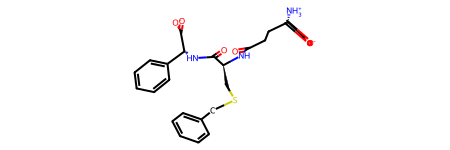

In [8]:
mol

In [9]:
# Set Maximum Length
max_length = 400  # Maximum number of amino acids

# Load Protein Structure (replace with your PDB file path)
parser = PDBParser()
structure = parser.get_structure("protein", "/content/refined-set/10gs/10gs_protein.pdb")

/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3299
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 6563
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6733
  warnings.warn(


In [10]:
# Using C-N
ppb = PPBuilder()
for pp in ppb.build_peptides(structure):
    print(pp.get_sequence())

# # Using CA-CA
# ppb = CaPPBuilder()
# for pp in ppb.build_peptides(structure):
#     print(pp.get_sequence())

PYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKASCLYGQLPKFQDGDLTLYQSNTILRHLGRTLGLYGKDQQEAALVDMVNDGVEDLRCKYISLIYTNYEAGKDDYVKALPGQLKPFETLLSQNQGGKTFIVGDQISFADYNLLDLLLIHEVLAPGCLDAFPLLSAYVGRLSARPKLKAFLASPEYVNLPINGNGKQ
PYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKASCLYGQLPKFQDGDLTLYQSNTILRHLGRTLGLYGKDQQEAALVDMVNDGVEDLRCKYISLIYTNYEAGKDDYVKALPGQLKPFETLLSQNQGGKTFIVGDQISFADYNLLDLLLIHEVLAPGCLDAFPLLSAYVGRLSARPKLKAFLASPEYVNLPINGNGKQ


In [11]:
# Extract Amino Acid Sequence and Masses
ppb = PPBuilder()
aa_masses = []
total_mass = 0
for pp in ppb.build_peptides(structure):
  ppb = ProteinAnalysis(pp.get_sequence())
  aa_masses+=([ppb.get_amino_acids_percent()[aa] * 100 for aa in ppb.sequence])

print(len(aa_masses))

416


In [12]:
aa_masses = []
for residue in structure.get_residues():
    if residue.get_resname() !='HOH':
        aa_masses.append(ProteinAnalysis(residue.get_resname()).molecular_weight())
    # else:
    #     # Handle non-standard or modified residues (you might need to estimate their mass)
    #     aa_masses.append(0)  # Or some default value

In [ ]:
aa_masses

In [74]:
len(aa_masses)

416

In [ ]:
count=0
for residue in structure.get_residues():
  if residue.get_resname() == "HOH":
    continue
  print(residue.get_resname())
  count+=1
print(count)

In [13]:
# Calculate distances between amino acid Cα atoms and ligand center
aa_coords = [residue["CA"].get_coord() for residue in structure.get_residues() if "CA" in residue and residue.get_resname()!='HOH']
ligand_coord = mol.GetConformer().GetPositions().mean(axis=0)  # Assuming a single conformer
distances = cdist(aa_coords, [ligand_coord])

# Sort residues by distance (ascending)
sorted_indices = distances.argsort(axis=0).flatten()

In [ ]:
distances

In [ ]:
sorted_indices

In [16]:
len(distances)

416

In [17]:
aa_coords[:2]

[array([31.195,  2.392, 37.963], dtype=float32),
 array([28.011,  2.405, 35.85 ], dtype=float32)]

In [14]:
# Calculate geometric centers of amino acids and ligand
aa_coords_geo = [residue.center_of_mass() for residue in structure.get_residues() if residue.get_resname()!='HOH']
ligand_coord = mol.GetConformer().GetPositions().mean(axis=0)

In [15]:
aa_coords_geo

[array([30.609262 ,  2.3635955, 38.54788  ], dtype=float32),
 array([29.543512 ,  2.1507502, 34.171734 ], dtype=float32),
 array([24.124012 ,  3.1547773, 37.21589  ], dtype=float32),
 array([21.161695 ,  1.5693597, 34.26323  ], dtype=float32),
 array([17.885176,  4.315529, 35.819168], dtype=float32),
 array([14.641759 ,  1.8353647, 31.363283 ], dtype=float32),
 array([11.076965 ,  2.0791984, 32.854645 ], dtype=float32),
 array([10.912437, -3.25    , 33.443806], dtype=float32),
 array([11.91381  , -2.6877372, 29.420675 ], dtype=float32),
 array([14.545206, -6.172326, 25.734114], dtype=float32),
 array([14.396558 , -0.7723331, 24.712185 ], dtype=float32),
 array([15.5097065,  4.339846 , 23.434566 ], dtype=float32),
 array([18.631819  ,  0.47812155, 27.69888   ], dtype=float32),
 array([19.474785 , -2.8250992, 24.688448 ], dtype=float32),
 array([22.279606 , -1.3246367, 23.043148 ], dtype=float32),
 array([23.294706 ,  0.5870327, 26.761873 ], dtype=float32),
 array([20.999187 , -3.1611154

In [71]:
distances_geo = cdist(aa_coords_geo, [ligand_coord])

# Sort residues by distance (ascending)
sorted_indices_geo = distances_geo.argsort(axis=0).flatten()

In [72]:
sorted_indices_geo

array([ 49,  50,   6,   5,  51,  11,  48,  36, 106, 203,  10,  42, 102,
         8,  62, 202,  63,  31,  45,  12,  33,  47,   7,   4, 304, 204,
        61,  99,  52,  41,  37,  98,  32, 105, 103, 201,  46, 101, 200,
        35,  95,  39,  64,  43, 107,  30, 308,   3, 301,   9,  13,  44,
       300, 331,  66, 205, 206,  34,  15,  16, 199,  65,  53,  40, 307,
        60, 297, 104, 305,  14,  29, 303, 330,  38, 334,  28, 155, 159,
        67, 100, 152,  96,  59, 207, 302,   2,  97, 156, 327, 108,  94,
        54, 109, 298, 335,  91, 299, 196, 311, 333, 296, 324,  68,  17,
       160, 332,  92,  27, 328, 306,  93, 329,  26, 163, 195, 116, 293,
       338, 337, 310, 110, 294, 198,  70, 162, 158,  69,  58, 323,  18,
        19, 148, 153, 197, 112, 272,   1, 312, 149, 154, 309, 151, 157,
       364, 295, 113,  55, 190, 326, 315, 111, 320, 316, 361, 276, 360,
       325,  56, 191,  88,  90, 219, 194, 368, 336, 270, 123, 341, 357,
       292,  20,  71, 193, 120, 349, 164, 271,   0, 150, 161,  5

In [73]:
len(distances_geo)

416

In [74]:
# Select residues to keep (based on max_length)
residues_to_keep = sorted_indices_geo[:max_length]
residues_to_remove = sorted_indices_geo[max_length:]


In [75]:
residues_to_keep

array([ 49,  50,   6,   5,  51,  11,  48,  36, 106, 203,  10,  42, 102,
         8,  62, 202,  63,  31,  45,  12,  33,  47,   7,   4, 304, 204,
        61,  99,  52,  41,  37,  98,  32, 105, 103, 201,  46, 101, 200,
        35,  95,  39,  64,  43, 107,  30, 308,   3, 301,   9,  13,  44,
       300, 331,  66, 205, 206,  34,  15,  16, 199,  65,  53,  40, 307,
        60, 297, 104, 305,  14,  29, 303, 330,  38, 334,  28, 155, 159,
        67, 100, 152,  96,  59, 207, 302,   2,  97, 156, 327, 108,  94,
        54, 109, 298, 335,  91, 299, 196, 311, 333, 296, 324,  68,  17,
       160, 332,  92,  27, 328, 306,  93, 329,  26, 163, 195, 116, 293,
       338, 337, 310, 110, 294, 198,  70, 162, 158,  69,  58, 323,  18,
        19, 148, 153, 197, 112, 272,   1, 312, 149, 154, 309, 151, 157,
       364, 295, 113,  55, 190, 326, 315, 111, 320, 316, 361, 276, 360,
       325,  56, 191,  88,  90, 219, 194, 368, 336, 270, 123, 341, 357,
       292,  20,  71, 193, 120, 349, 164, 271,   0, 150, 161,  5

In [76]:
residues_to_keep.sort()

In [77]:
residues_to_keep

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [69]:
residues_to_remove

array([237, 243, 396, 231, 406, 394, 400, 401, 246, 242, 393, 397, 235,
       208, 233, 402])

In [97]:
aa_masses[50]

410.3248

In [98]:
# Truncate feature arrays based on distance
aa_masses_filtered = [aa_masses[i] for i in residues_to_keep]

In [99]:
aa_masses_filtered[50]

410.3248

In [ ]:
aa_masses_filtered

In [54]:
len(aa_masses)

400

##Distance matrix

In [28]:
matrix_size=max_length+1

In [115]:
# Update distance matrix
aa_coords_to_keep = [aa_coords_geo[i] for i in residues_to_keep]
all_cordinates=aa_coords_to_keep+[ligand_coord]
distances_truncated = cdist(all_cordinates, all_cordinates)
#distance_matrix = np.zeros((matrix_size, matrix_size))


In [118]:
#istance_matrix.shape

In [117]:
distances_truncated.shape

(401, 401)

In [119]:
type(distances_truncated)

numpy.ndarray

In [120]:
distances_truncated

array([[ 0.        ,  4.509076  ,  6.66773108, ..., 47.98232646,
        46.80152452, 23.65876893],
       [ 4.509076  ,  0.        ,  6.2965018 , ..., 44.76961841,
        43.89223271, 21.12787027],
       [ 6.66773108,  6.2965018 ,  0.        , ..., 43.19499477,
        42.40672492, 17.31877785],
       ...,
       [47.98232646, 44.76961841, 43.19499477, ...,  0.        ,
         6.25296843, 29.21021032],
       [46.80152452, 43.89223271, 42.40672492, ...,  6.25296843,
         0.        , 30.04584172],
       [23.65876893, 21.12787027, 17.31877785, ..., 29.21021032,
        30.04584172,  0.        ]])

In [ ]:
# distance_matrix[:max_length, -1] = distances_truncated
# distance_matrix[-1, :max_length] = distances_truncated.T

In [121]:
distances_truncated[395:,395:]

array([[ 0.        ,  4.03554274,  5.72274142,  7.53341136, 10.20551251,
        30.56496822],
       [ 4.03554274,  0.        ,  3.95506141,  3.9610275 ,  8.68987564,
        29.76971862],
       [ 5.72274142,  3.95506141,  0.        ,  4.06852423,  6.25408786,
        32.15838046],
       [ 7.53341136,  3.9610275 ,  4.06852423,  0.        ,  6.25296843,
        29.21021032],
       [10.20551251,  8.68987564,  6.25408786,  6.25296843,  0.        ,
        30.04584172],
       [30.56496822, 29.76971862, 32.15838046, 29.21021032, 30.04584172,
         0.        ]])

##Molecular mass

In [126]:
Descriptors.MolWt(mol)

472.5430000000002

In [122]:
aa_mass_channel = np.zeros((matrix_size, matrix_size))


In [123]:
np.fill_diagonal(aa_mass_channel, aa_masses_filtered + [Descriptors.MolWt(mol)])  # Padded/truncated masses

In [124]:
aa_mass_channel

array([[508.6143,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
       [  0.    , 438.4781,   0.    , ...,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    , 412.4442, ...,   0.    ,   0.    ,   0.    ],
       ...,
       [  0.    ,   0.    ,   0.    , ..., 381.4234,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    , ...,   0.    , 302.3268,   0.    ],
       [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    , 472.543 ]])

In [127]:
aa_mass_channel.shape

(401, 401)

##Van Der Waals radius

In [136]:
# # 3. Van der Waals Radius (example calculation)
# vdw_radii = [ppb.get_amino_acids_percent()[aa] * 1.5 for aa in ppb.sequence]
# # Pad/truncate vdw_radii if needed, similar to aa_masses
# lst=aa_masses_filtered + [Descriptors.MolMR(mol)]
# vdw_radii_channel = np.zeros((matrix_size, matrix_size))
# np.fill_diagonal(vdw_radii_channel, lst)

In [33]:
ptable = fetch_table("elements")

In [34]:
cols = ["symbol",
    "vdw_radius_dreiding"
]

In [39]:
ptable=ptable[cols]

In [40]:
ptable.dropna(inplace=True)

In [51]:
van_dict=ptable.set_index('symbol').T.to_dict('index')['vdw_radius_dreiding']

In [52]:
van_dict

{'H': 319.5,
 'B': 401.99999999999994,
 'C': 389.83,
 'N': 366.21000000000004,
 'O': 340.46,
 'F': 347.2,
 'Al': 438.99999999999994,
 'Si': 426.99999999999994,
 'P': 415.00000000000006,
 'S': 403.0,
 'Cl': 395.03,
 'Ga': 438.99999999999994,
 'Ge': 426.99999999999994,
 'As': 415.00000000000006,
 'Se': 403.0,
 'Br': 395.0,
 'In': 459.0,
 'Sn': 447.0,
 'Sb': 434.99999999999994,
 'Te': 423.00000000000006,
 'I': 415.00000000000006}

In [68]:
# Calculate Amino Acid Van der Waals Radii (Mendeleev example)
aa_vdw_radii = []
for residue in structure.get_residues():
    if residue.get_resname() !='HOH':
        atoms = [atom.element for atom in residue.get_atoms()]
        #print(atoms)
        radii = [van_dict[atom] for atom in atoms]
        #print(radii)

        aa_vdw_radii.append(np.mean(radii))  # Average radii



In [ ]:
aa_vdw_radii

In [78]:
aa_vdw_radii_filtered = [aa_vdw_radii[i] for i in residues_to_keep]

In [79]:
# Calculate Ligand Van der Waals Radius (Mendeleev example)
ligand_vdw_radius = []

for atom in mol.GetAtoms():
    atomic_symbol = atom.GetSymbol()
    radius = van_dict[atomic_symbol] #if atomic_symbol in van_dict else 0
    ligand_vdw_radius.append(radius)

ligand_vdw_radius = np.mean(ligand_vdw_radius)  # average radii

In [59]:
ligand_vdw_radius

379.10545454545445

In [82]:

# Calculate Ligand Van der Waals Radius (RDKit example)
#ligand_vdw_radius = Descriptors.RadiusOfGyration(mol)

# Create Channel
vdw_radii_channel = np.diag(aa_vdw_radii_filtered + [ligand_vdw_radius])

In [84]:
vdw_radii_channel[-1][-1]

379.10545454545445

In [83]:
vdw_radii_channel.shape

(401, 401)

In [ ]:
# [Descriptors.MolMR(mol)]

In [ ]:
# vdw_radii + [Descriptors.MolMR(mol)]

In [85]:
Descriptors.MolLogP(mol)

-1.8473999999999928